In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D , Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet_v2 import ResNet101V2, preprocess_input
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [21]:
trainPath = 'chinese_dataset/tsrd-train'
testPath = 'chinese_dataset/TSRD-Test'
labelFile = 'chinese_dataset/labels.csv'
testAnnotationPath = 'chinese_dataset/TSRD-Test Annotation/TsignRecgTest1994Annotation.txt'
trainAnnotationPath = 'chinese_dataset/TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt'
batch_size_val = 64
epochs_val = 500
imageDimesions = (32, 32, 3)
validationRatio = 0.2

In [22]:
# Read annotations
trainAnnotation = pd.read_csv(trainAnnotationPath, delimiter=";", header=None)
testAnnotation = pd.read_csv(testAnnotationPath, delimiter=";", header=None)

In [23]:
X_train = []
y_train = []
X_test = []
y_test = []

importedClasses = []

# Importing train set
print("Importing Train Set Classes...")
# pictureList = os.listdir(trainPath)
for j, row in trainAnnotation.iterrows():
    x = row[0]
    img = cv2.imread(os.path.join(trainPath, str(x)))

    classIndex = row[7]

    if classIndex not in importedClasses:
        print(classIndex, end = " ")
        importedClasses.append(classIndex)

    # Crop image based on dataset
    # row = trainAnnotation[trainAnnotation[0] == x]
    yLeft, yRight = row[4], row[6]
    xLeft, xRight = row[3], row[5]
    img = img[yLeft:yRight, xLeft:xRight]

    X_train.append(img)
    y_train.append(classIndex)

# Importing test set
print("\n\nImporting Test Set Classes...")
# pictureList = os.listdir(testPath)
for j, row in testAnnotation.iterrows():
    x = row[0]
    img = cv2.imread(os.path.join(testPath, str(x)))

    classIndex = row[7]

    # Crop image based on dataset
    # row = trainAnnotation[trainAnnotation[0] == x]
    yLeft, yRight = row[4], row[6]
    xLeft, xRight = row[3], row[5]
    img = img[yLeft:yRight, xLeft:xRight]

    X_test.append(img)
    y_test.append(classIndex)

noOfClasses = len(importedClasses)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Importing Train Set Classes...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 

Importing Test Set Classes...
<ipython-input-23-442ab94b5241>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_train = np.array(X_train)
<ipython-input-23-442ab94b5241>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_test = np.array(X_test)


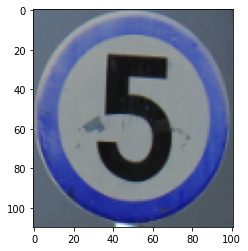

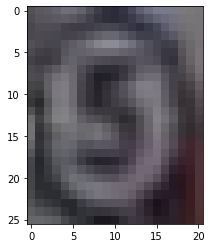

In [24]:
plt.imshow(X_train[0])
plt.show()

plt.imshow(X_test[0])
plt.show()

In [25]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validationRatio)

In [26]:
print("Data Shapes")
print("Train",end = "")
print(X_train.shape,y_train.shape)
print("Validation",end = "")
print(X_validation.shape,y_validation.shape)
print("Test",end = "")
print(X_test.shape,y_test.shape)
assert(X_train.shape[0] == y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0] == y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images in not equal to the number of lables in test set"

Data Shapes
Train(3336,) (3336,)
Validation(834,) (834,)
Test(1994,) (1994,)


In [27]:
data = pd.read_csv(labelFile)
print("Data shape:", data.shape, type(data))

Data shape: (58, 2) <class 'pandas.core.frame.DataFrame'>


[96, 31, 63, 212, 80, 158, 65, 122, 7, 2, 52, 109, 77, 28, 102, 20, 115, 109, 7, 3, 13, 9, 13, 9, 80, 2, 101, 22, 360, 38, 110, 32, 12, 1, 19, 125, 35, 48, 25, 29, 20, 13, 29, 69, 24, 22, 14, 10, 7, 32, 48, 6, 33, 1, 252, 126, 85, 4]


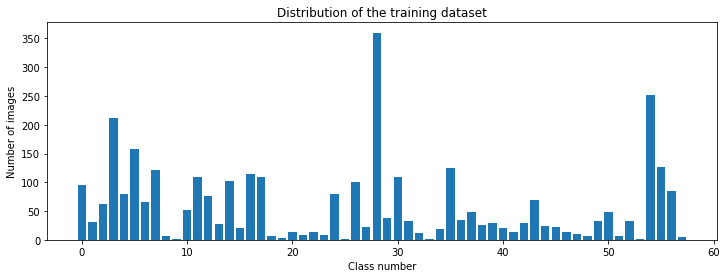

In [28]:
num_of_samples = [len(X_train[y_train == i]) for i in range(noOfClasses)]
print(num_of_samples)

plt.figure(figsize = (12, 4))
plt.bar(range(0, noOfClasses), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [29]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def sobel(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
    img = (grad * 255 / grad.max()).astype(np.uint8)
    return img

def resize(img):
    img = cv2.resize(img, (imageDimesions[0], imageDimesions[1]))
    return img

def preprocessing(img):
    img = resize(img)
    img = grayscale(img)
    img = equalize(img)
    # img = sobel(img)
    img = img / 255       
    return img

In [30]:
X_train = np.array(list(map(preprocessing,X_train))) 
X_validation = np.array(list(map(preprocessing,X_validation)))
X_test = np.array(list(map(preprocessing,X_test)))

In [31]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [32]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

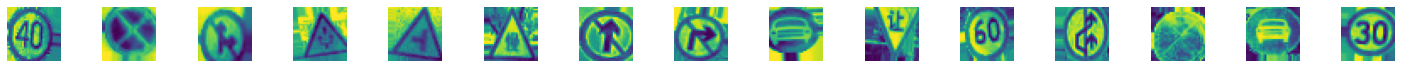

In [33]:
fig,axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]))
    axs[i].axis('off')
plt.show()

In [34]:
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [35]:
def myModel():
    model = Sequential()
    model.add((Conv2D(64, (5, 5), input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu')))
    model.add((Conv2D(64, (5, 5), activation='relu')))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add((Conv2D(32, (3, 3), activation='relu')))
    model.add((Conv2D(32, (3, 3), activation='relu')))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax')) 
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model = myModel()
print(model.summary())

checkpoint = ModelCheckpoint("checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(
        dataGen.flow(X_train, y_train, batch_size = batch_size_val),
        epochs = epochs_val,
        validation_data = (X_validation, y_validation),
        shuffle = 1,
        callbacks = [checkpoint, early]
    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 9, 32)         24608     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 6, 32)          12320     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 3, 32)         

KeyboardInterrupt: 

In [1]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [110]:
model.save('trained_model_chinese_local')

INFO:tensorflow:Assets written to: trained_model_chinese/assets
